### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

import os
from random import shuffle
from PIL import Image
import h5py

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, SubsetRandomSampler

### Parameters

In [10]:
MEDICAL_DATA = '/net/archive/groups/plggneurony/swilczyn/medical/datasets/medical-4channels-cropped.h5'
OUTPUT = '/net/archive/groups/plggneurony/swilczyn/medical/datasets/small-medical-4channels-cropped-{}.h5'

BATCH_SIZE = 1024

### Dataset

In [11]:
class MedicalDataset(Dataset):
    def __init__(self, images, masks, patch_size=32):
        self.images = images
        self.masks = masks
        
        self.patch_size = patch_size
        
        self.images_count, self.image_size, _, _ = self.images.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.images_count * self.patches_per_image
    
    def __getitem__(self, idx):
        image_idx = idx // self.patches_per_image
        patch_idx = idx % self.patches_per_image
        
        image = self.images[image_idx]
        mask = self.masks[image_idx]
        
        y = patch_idx // self.patches_per_side
        x = patch_idx % self.patches_per_side
        
        patch = image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1)
        label = mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0))
        
        return (patch, label)

### Dataset statistics

In [12]:
def statistic_of_sums(patch_size, dataset='train', alpha = 0.75, batch_size=2**14):
    with h5py.File(MEDICAL_DATA, 'r') as f:
            images = f[dataset]['images'][...]
            masks = f[dataset]['masks'][...]

    dataset = MedicalDataset(images, masks, patch_size=patch_size)
    loader = DataLoader(dataset, batch_size=2**14, num_workers=8)
    
    data_sums = []
    positive_data_sums = []

    for i, (data, labels) in enumerate(loader):
        batch_sum = data.reshape(data.shape[0], -1).sum(1).data.numpy()
        positive_batch_sum = batch_sum[labels.nonzero().numpy()].ravel()

        data_sums.extend([v.item() for v in batch_sum])
        positive_data_sums.extend([v.item() for v in positive_batch_sum])

        if i % 500 == 0: print('[{:.3f}%]'.format(100. * i / len(loader)))
            
    plt.figure(figsize=(15, 5))
    plt.hist(positive_data_sums, bins=200)
    plt.title('Sums of images with positive label')
    plt.show()
    
    plt.figure(figsize=(15, 5))
    plt.hist(data_sums, bins=200)

    m, M = min(positive_data_sums), max(positive_data_sums)
    plt.axvline(m, c='r')
    plt.axvline(M, c='r')
    plt.text(m, 0.5 * plt.ylim()[1], '{:.3f}'.format(m))
    plt.text(M, 0.5 * plt.ylim()[1], '{:.3f}'.format(M))

    plt.axvline(alpha * m, c='g', ls='--')
    plt.text(alpha * m, 0.75 * plt.ylim()[1], '{:.3f}'.format(alpha * m))

    plt.title('Sums of images')
    plt.show()

In [13]:
statistic_of_sums(patch_size=32)

[0.000%]
[5.814%]
[11.628%]
[17.442%]
[23.256%]
[29.070%]
[34.884%]
[40.698%]
[46.512%]
[52.326%]
[58.140%]
[63.953%]
[69.767%]
[75.581%]
[81.395%]


[0.000%]
[37.651%]
[75.301%]


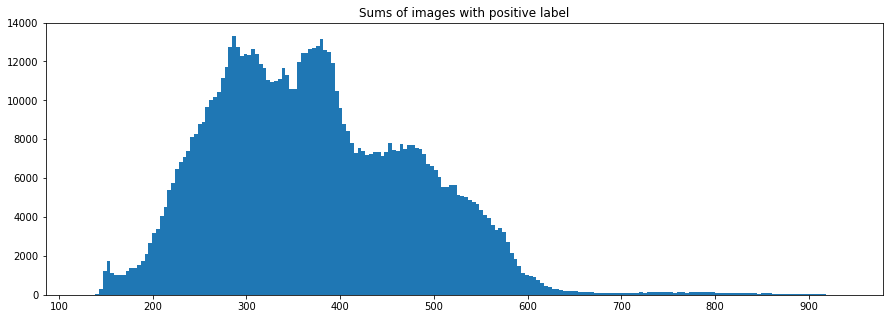

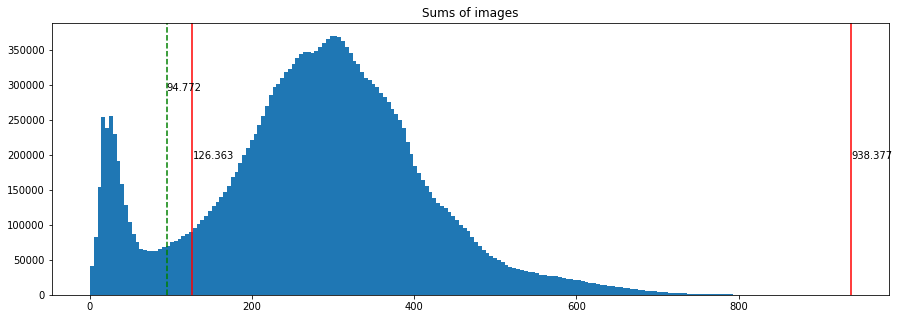

In [14]:
statistic_of_sums(patch_size=22, dataset='test')

### Prepare small dataset

In [15]:
def create_small_dataset(patch_size, sum_threshold=0., train_slice=0.001, test_pos_slice=0.005, batch_size=2**13):
    with h5py.File(MEDICAL_DATA, 'r') as f:
        train_images = f['train']['images'][...]
        train_masks = f['train']['masks'][...]
        
    train_dataset = MedicalDataset(train_images, train_masks, patch_size=patch_size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=12)
    
    train_sums = []
    for i, (data, labels) in enumerate(train_loader):
        batch_sums = data.reshape(data.shape[0], -1).sum(1).data.numpy()
        train_sums.extend([v.item() for v in batch_sums])
        if i % 1000 == 0: print('[{:.3f}%]'.format(100. * i / len(train_loader)))
            
    indices = (np.array(train_sums) > sum_threshold).nonzero()[0]
            
    train_samples_count = min(int(len(train_dataset) * train_slice), len(indices))
    train_indices = np.random.choice(indices, train_samples_count, replace=False)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, sampler=SubsetRandomSampler(train_indices))
    
    img, _ = train_dataset[0]
    img_shape = img.shape
    
    with h5py.File(OUTPUT.format(patch_size), 'a') as f:
        if 'train/images' in f: del f['train/images']
        if 'train/labels' in f: del f['train/labels']
        
        f.create_dataset('train/images', (train_samples_count, *img_shape), compression="gzip")
        f.create_dataset('train/labels', (train_samples_count,), compression="gzip")
        
        for i, (batch_images, batch_labels) in enumerate(train_loader):
            f['train/images'][i * batch_size : i * batch_size + len(batch_images)] = batch_images
            f['train/labels'][i * batch_size : i * batch_size + len(batch_labels)] = batch_labels
            print('[{:.2f}%]'.format(100. * i / len(train_loader)))
            
    with h5py.File(MEDICAL_DATA, 'r') as f:
        test_images = f['test']['images'][...]
        test_masks = f['test']['masks'][...]
        
        test_positive_indices = f['test']['patches'][str(patch_size)]['positives'][...]
        test_negative_indices = f['test']['patches'][str(patch_size)]['negatives'][...]
        
    test_dataset = MedicalDataset(test_images, test_masks, patch_size=patch_size)
    
    test_samples_count = int(len(test_positive_indices) * test_pos_slice)
    test_pos_indices = np.random.choice(test_positive_indices, test_samples_count, replace=False)
    test_neg_indices = np.random.choice(test_negative_indices, test_samples_count, replace=False)
    
    test_pos_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, sampler=SubsetRandomSampler(test_pos_indices))
    test_neg_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, sampler=SubsetRandomSampler(test_neg_indices))
    
    with h5py.File(OUTPUT.format(patch_size), 'a') as f:
        if 'test/images' in f: del f['test/images']
        if 'test/labels' in f: del f['test/labels']
        
        f.create_dataset('test/images', (2 * test_samples_count, *img_shape), compression="gzip")
        f.create_dataset('test/labels', (2 * test_samples_count,), compression="gzip")
        
        for i, (batch_images, batch_labels) in enumerate(test_neg_loader):
            f['test/images'][i * batch_size : i * batch_size + len(batch_images)] = batch_images
            f['test/labels'][i * batch_size : i * batch_size + len(batch_labels)] = batch_labels
            print('[{:.2f}%]'.format(100. * i / len(test_neg_loader)))
            
        offset = test_samples_count
        
        for i, (batch_images, batch_labels) in enumerate(test_pos_loader):
            f['test/images'][offset + i * batch_size : offset + i * batch_size + len(batch_images)] = batch_images
            f['test/labels'][offset + i * batch_size : offset + i * batch_size + len(batch_labels)] = batch_labels
            print('[{:.2f}%]'.format(100. * i / len(test_pos_loader)))
    

In [16]:
create_small_dataset(22, train_slice=0.001, test_pos_slice=0.005, sum_threshold=50)

[0.000%]
[15.126%]
[30.253%]
[45.379%]
[60.505%]
[75.632%]
[90.758%]
[0.00%]
[14.29%]
[28.57%]
[42.86%]
[57.14%]
[71.43%]
[85.71%]
[0.00%]
[0.00%]


In [51]:
patch_size = 32
sum_threshold = 42.
train_slice = 0.001
test_pos_slice = 0.005
batch_size = 2**13

In [52]:
with h5py.File(MEDICAL_DATA, 'r') as f:
    train_images = f['train']['images'][...]
    train_masks = f['train']['masks'][...]

train_dataset = MedicalDataset(train_images, train_masks, patch_size=patch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=12, sampler=SequentialSampler(train_dataset))

In [54]:
train_sums = np.zeros(len(train_dataset), dtype=float)

for i, (data, labels) in enumerate(train_loader):    
    train_sums[i * train_loader.batch_size : i * train_loader.batch_size + len(data)] = data.reshape(data.shape[0], -1).sum(1)
    
    if i % 1000 == 0: print('[{:.3f}%]'.format(100. * i / len(train_loader)))
        
indices = (np.array(train_sums) > sum_threshold).nonzero()[0]

[0.000%]
[5.330%]
[10.660%]
[15.990%]
[21.320%]
[26.650%]
[31.980%]
[37.309%]
[42.639%]
[47.969%]
[53.299%]
[58.629%]
[63.959%]
[69.289%]
[74.619%]
[79.949%]
[85.279%]
[90.609%]
[95.939%]


In [55]:
train_samples_count = min(2 ** 18, len(indices))
train_indices = np.random.choice(indices, train_samples_count, replace=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, sampler=SubsetRandomSampler(train_indices))

In [56]:
img, _ = train_dataset[0]
img_shape = img.shape

In [57]:
with h5py.File(OUTPUT.format(patch_size), 'a') as f:
    if 'train/images' in f: del f['train/images']
    if 'train/labels' in f: del f['train/labels']

    f.create_dataset('train/images', (train_samples_count, *img_shape), compression="gzip")
    f.create_dataset('train/labels', (train_samples_count,), compression="gzip")

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        f['train/images'][i * batch_size : i * batch_size + len(batch_images)] = batch_images
        f['train/labels'][i * batch_size : i * batch_size + len(batch_labels)] = batch_labels
        print('[{:.2f}%]'.format(100. * i / len(train_loader)))

[0.00%]
[3.12%]
[6.25%]
[9.38%]
[12.50%]
[15.62%]
[18.75%]
[21.88%]
[25.00%]
[28.12%]
[31.25%]
[34.38%]
[37.50%]
[40.62%]
[43.75%]
[46.88%]
[50.00%]
[53.12%]
[56.25%]
[59.38%]
[62.50%]
[65.62%]
[68.75%]
[71.88%]
[75.00%]
[78.12%]
[81.25%]
[84.38%]
[87.50%]
[90.62%]
[93.75%]
[96.88%]


In [10]:
with h5py.File(MEDICAL_DATA, 'r') as f:
    test_images = f['test']['images'][...]
    test_masks = f['test']['masks'][...]

test_dataset = MedicalDataset(test_images, test_masks, patch_size=patch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16, sampler=SequentialSampler(test_dataset))

In [30]:
test_labels = np.zeros(len(test_dataset), dtype=int)
test_sums = np.zeros(len(test_dataset), dtype=float)

for i, (data, labels) in enumerate(test_loader):    
    test_sums[i * test_loader.batch_size : i * test_loader.batch_size + len(data)] = data.reshape(data.shape[0], -1).sum(1)
    test_labels[i * test_loader.batch_size : i * test_loader.batch_size + len(labels)] = labels
    
    if i % 1000 == 0: print('[{:.3f}%]'.format(100. * i / len(test_loader)))

[0.000%]
[12.943%]
[25.887%]
[38.830%]
[51.773%]
[64.717%]
[77.660%]
[90.603%]


In [38]:
test_pos_indices = np.logical_and(test_labels == 1, test_sums > sum_threshold).nonzero()[0]
test_neg_indices = np.logical_and(test_labels == 0, test_sums > sum_threshold).nonzero()[0]

In [45]:
test_samples_count = min(2 ** 13, len(test_pos_indices), len(test_neg_indices))
sub_test_pos_indices = np.random.choice(test_pos_indices, test_samples_count, replace=False)
sub_test_neg_indices = np.random.choice(test_neg_indices, test_samples_count, replace=False)

test_pos_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16, sampler=SubsetRandomSampler(sub_test_pos_indices))
test_neg_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16, sampler=SubsetRandomSampler(sub_test_neg_indices))

In [46]:
img, _ = test_dataset[0]
img_shape = img.shape

In [47]:
with h5py.File(OUTPUT.format(patch_size), 'a') as f:
    if 'test/images' in f: del f['test/images']
    if 'test/labels' in f: del f['test/labels']

    f.create_dataset('test/images', (2 * test_samples_count, *img_shape), compression="gzip")
    f.create_dataset('test/labels', (2 * test_samples_count,), compression="gzip")

    for i, (batch_images, batch_labels) in enumerate(test_neg_loader):
        f['test/images'][i * batch_size : i * batch_size + len(batch_images)] = batch_images
        f['test/labels'][i * batch_size : i * batch_size + len(batch_labels)] = batch_labels
        print('[{:.2f}%]'.format(100. * i / len(test_neg_loader)))

    offset = test_samples_count

    for i, (batch_images, batch_labels) in enumerate(test_pos_loader):
        f['test/images'][offset + i * batch_size : offset + i * batch_size + len(batch_images)] = batch_images
        f['test/labels'][offset + i * batch_size : offset + i * batch_size + len(batch_labels)] = batch_labels
        print('[{:.2f}%]'.format(100. * i / len(test_pos_loader)))

[0.00%]
[0.00%]


In [49]:
with h5py.File(OUTPUT.format(patch_size), 'r') as f:
    test_images = f['test']['images'][...]
    test_labels = f['test']['labels'][...]

In [50]:
test_labels.sum()

8192.0

### Samples from small dataset

In [18]:
import os.path, sys
sys.path.append(os.path.abspath(os.path.join('..')))

from medicalCommon import SmallMedicalLoader

In [19]:
dataset_path = '/net/archive/groups/plggneurony/swilczyn/medical/datasets/small-medical-4channels-cropped-22.h5'
batch_size = 4096
num_workers = 8

In [20]:
loader = SmallMedicalLoader(dataset_path=dataset_path, batch_size=batch_size, num_workers=num_workers)

train_loader = loader.train_loader()
test_loader = loader.test_loader()

In [21]:
samples = len(test_loader.dataset)
X, Y = np.zeros((samples, 22, 22, 3)), np.zeros(samples)

for i, (data, labels) in enumerate(test_loader):
    X[i * batch_size : i * batch_size + len(data)] = data.permute(0, 2, 3, 1)[:,:,:,:3]
    Y[i * batch_size : i * batch_size + len(data)] = labels

Samples with negative label


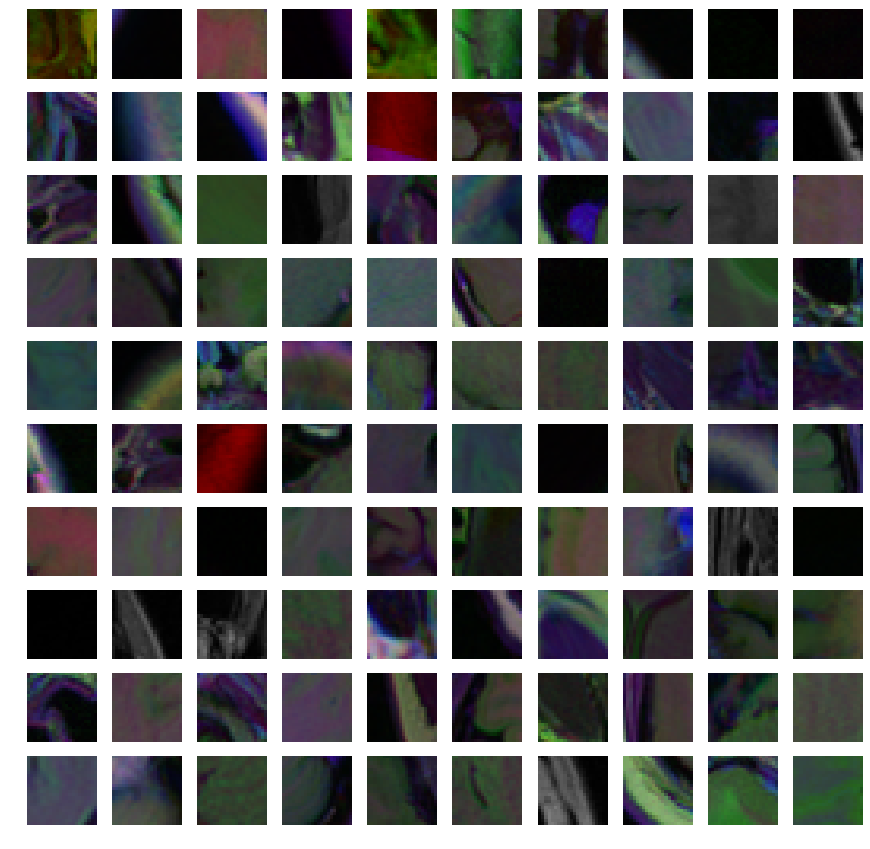

Samples with positive label


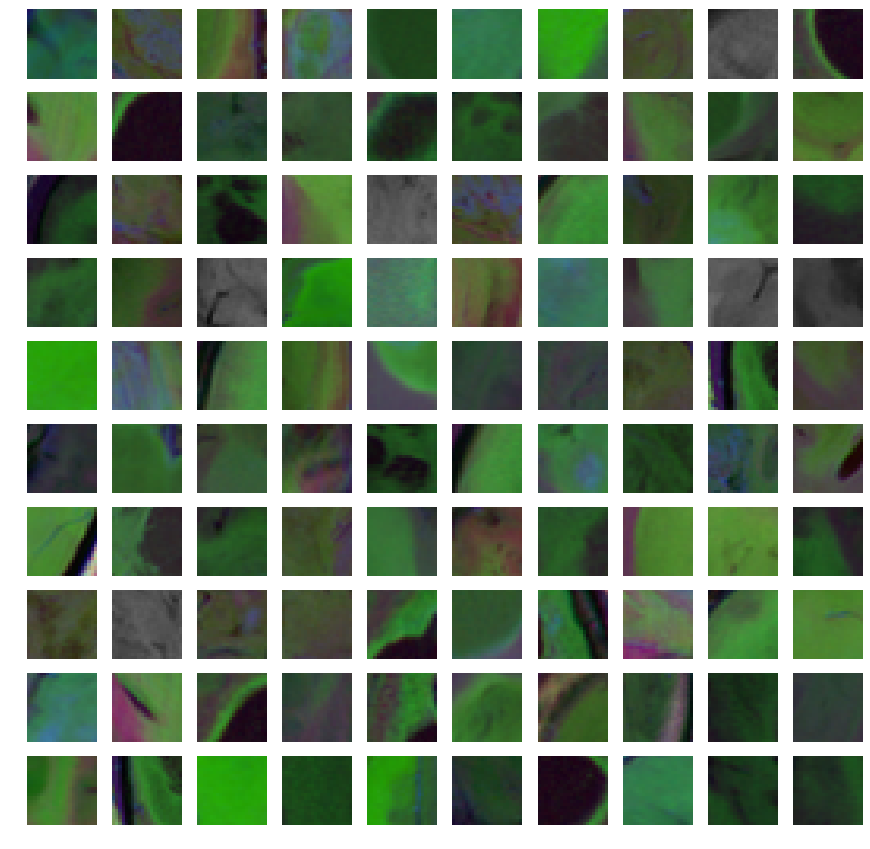

In [22]:
for i, label in [(0, 'negative'), (1, 'positive')]:
    print(f'Samples with {label} label')
    plt.figure(figsize=(15, 15))
    indices = np.random.choice((Y == i).nonzero()[0], 10**2, replace=False)
    
    for j in range(10**2):
        plt.subplot(10, 10, j + 1)
        plt.imshow(X[indices[j]])
        plt.axis('off')
    
    plt.show()